<a href="https://colab.research.google.com/github/hugoalfedoputra-ub/ml/blob/main/nn_course/T1/Tugas_1_PyTorch_Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [2]:
print('Train dataset size: ', len(train_dataset))
print('test dataset size: ', len(test_dataset))
print('Loaded train size: ', len(train_loader))
print('Loaded test size: ', len(test_loader))

Train dataset size:  60000
test dataset size:  10000
Loaded train size:  600
Loaded test size:  100


In [3]:
import matplotlib.pyplot as plt

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [4]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
losses = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Move tensors to the configured device
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (i+1) % 100 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.3231
Epoch [1/5], Step [200/600], Loss: 0.2250
Epoch [1/5], Step [300/600], Loss: 0.3713
Epoch [1/5], Step [400/600], Loss: 0.1668
Epoch [1/5], Step [500/600], Loss: 0.1718
Epoch [1/5], Step [600/600], Loss: 0.2156
Epoch [2/5], Step [100/600], Loss: 0.1390
Epoch [2/5], Step [200/600], Loss: 0.1133
Epoch [2/5], Step [300/600], Loss: 0.0479
Epoch [2/5], Step [400/600], Loss: 0.1742
Epoch [2/5], Step [500/600], Loss: 0.0365
Epoch [2/5], Step [600/600], Loss: 0.0750
Epoch [3/5], Step [100/600], Loss: 0.0717
Epoch [3/5], Step [200/600], Loss: 0.0443
Epoch [3/5], Step [300/600], Loss: 0.0163
Epoch [3/5], Step [400/600], Loss: 0.0851
Epoch [3/5], Step [500/600], Loss: 0.0526
Epoch [3/5], Step [600/600], Loss: 0.0678
Epoch [4/5], Step [100/600], Loss: 0.0399
Epoch [4/5], Step [200/600], Loss: 0.0972
Epoch [4/5], Step [300/600], Loss: 0.0549
Epoch [4/5], Step [400/600], Loss: 0.0918
Epoch [4/5], Step [500/600], Loss: 0.0378
Epoch [4/5], Step [600/600], Loss:

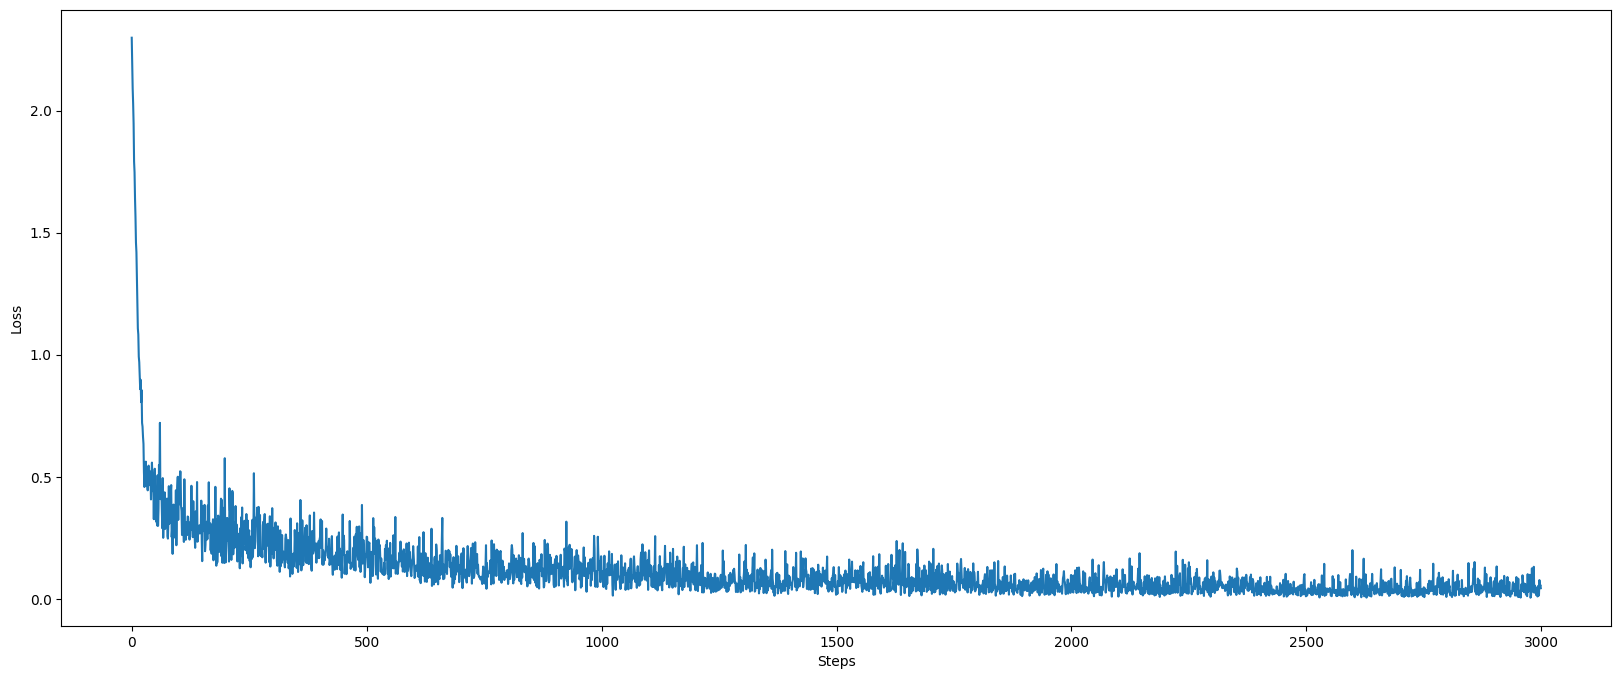

In [5]:
# Plotting penghitungan loss dari model contoh oleh yunjey
plt.figure(figsize=(20,8))
plt.plot(range(3000), losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [6]:
# !pip install -U "ray[tune]" --quiet
!pip install skorch --quiet

In [23]:
from skorch import NeuralNetClassifier
from skorch.dataset import Dataset
from sklearn.model_selection import RandomizedSearchCV

# Deklarasikan X dan y sebagai tensor untuk GridSearchCV
X = torch.cat([data for data, _ in train_dataset], dim=0)
y = torch.tensor(train_dataset.targets)

# Reshape X menjadi (number_of_samples, 784)
X = X.view(X.size(0), -1)

# Ini adalah kelas neural network yang dapat menerima parameter banyak hidden layer, besar
# hidden layer tersebut (dianggap sama untuk semua), satu fungsi aktivasi untuk neuron input
# dan hidden layer, dan implementasi softmax untuk neuron output (apabila softmax=True)
class MyNet(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_layers, activation, num_classes, softmax=True):
    super(MyNet, self).__init__()

    layers = []
    layers.append(nn.Linear(input_size, hidden_size))
    layers.append(activation())

    for _ in range(hidden_layers - 2):
      layers.append(nn.Linear(hidden_size, hidden_size))
      layers.append(activation())

    layers.append(nn.Linear(hidden_size, hidden_size))
    if softmax:
      layers.append(nn.Softmax(dim=1))
    else:
      layers.append(activation())

    layers.append(nn.Linear(hidden_size, num_classes))
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)

param_grid = {
  "module__hidden_layers": [1, 2, 3],
  "module__hidden_size": [400, 500, 600],
  "max_epochs": range(3, 10, 2),
  "batch_size": [100, 300, 600],
  "lr": [1e-2, 1e-3, 1e-4],
  "module__activation": [nn.ReLU, nn.LeakyReLU, nn.Sigmoid]
}

model = NeuralNetClassifier(
  module=MyNet,
  module__input_size=784,
  module__num_classes=10,
  criterion=nn.CrossEntropyLoss,
  optimizer=torch.optim.Adam,
  verbose=True
)

search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=15, n_jobs=-1, cv=5, verbose=3)
search_result = search.fit(X, y)

# Hasil RandomizedSearch
print("Best: %f using %s" % (search_result.best_score_, search_result.best_params_))

<ipython-input-23-1b17e31b1909>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(train_dataset.targets)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7648       0.8130        1.2276  17.4473
      2        0.9048       0.8441        0.6823  15.3841
      3        0.5718       0.8491        0.5248  15.5115
Best: 0.850250 using {'module__hidden_size': 400, 'module__hidden_layers': 2, 'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'max_epochs': 3, 'lr': 0.01, 'batch_size': 600}


Hasil RandomizedSearch
```
Fitting 5 folds for each of 15 candidates, totalling 75 fits
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7648       0.8130        1.2276  17.4473
      2        0.9048       0.8441        0.6823  15.3841
      3        0.5718       0.8491        0.5248  15.5115
Best: 0.850250 using {'module__hidden_size': 400, 'module__hidden_layers': 2, 'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'max_epochs': 3, 'lr': 0.01, 'batch_size': 600}
```

In [31]:
from pprint import pprint

pprint(search_result.cv_results_)

{'mean_fit_time': array([ 25.76211748, 406.07247658,  32.6550324 , 461.06494341,
        36.48139534,  58.19377413,  86.26021643,  26.14269991,
       108.35000811,  27.34807625,  31.69404082,  48.70340528,
        37.13466001, 135.05869155, 132.57700453]),
 'mean_score_time': array([0.99876261, 1.30301166, 1.08901854, 1.6303412 , 0.89456429,
       0.79002395, 1.22110229, 1.01155925, 1.40828638, 1.11396632,
       1.04843531, 1.11287117, 0.78827968, 1.6097548 , 1.11396928]),
 'mean_test_score': array([0.74038333, 0.8247    , 0.61338333, 0.65378333, 0.65368333,
       0.85025   , 0.6371    , 0.56995   , 0.32498333, 0.46226667,
       0.51238333, 0.72213333, 0.60315   , 0.16885   , 0.61073333]),
 'param_batch_size': masked_array(data=[100, 600, 100, 100, 300, 600, 300, 600, 300, 600, 300,
                   300, 600, 100, 600],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value

Hasil `search_results.cv_results_`

```
{'mean_fit_time': array([ 25.76211748, 406.07247658,  32.6550324 , 461.06494341,
        36.48139534,  58.19377413,  86.26021643,  26.14269991,
       108.35000811,  27.34807625,  31.69404082,  48.70340528,
        37.13466001, 135.05869155, 132.57700453]),
 'mean_score_time': array([0.99876261, 1.30301166, 1.08901854, 1.6303412 , 0.89456429,
       0.79002395, 1.22110229, 1.01155925, 1.40828638, 1.11396632,
       1.04843531, 1.11287117, 0.78827968, 1.6097548 , 1.11396928]),
 'mean_test_score': array([0.74038333, 0.8247    , 0.61338333, 0.65378333, 0.65368333,
       0.85025   , 0.6371    , 0.56995   , 0.32498333, 0.46226667,
       0.51238333, 0.72213333, 0.60315   , 0.16885   , 0.61073333]),
 'param_batch_size': masked_array(data=[100, 600, 100, 100, 300, 600, 300, 600, 300, 600, 300,
                   300, 600, 100, 600],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_lr': masked_array(data=[0.001, 0.01, 0.0001, 0.001, 0.0001, 0.01, 0.0001,
                   0.001, 0.01, 0.0001, 0.01, 0.01, 0.0001, 0.01, 0.01],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_max_epochs': masked_array(data=[3, 7, 3, 9, 7, 3, 9, 3, 7, 3, 3, 5, 7, 5, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_module__activation': masked_array(data=[<class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.Sigmoid'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.LeakyReLU'>,
                   <class 'torch.nn.modules.activation.Sigmoid'>,
                   <class 'torch.nn.modules.activation.Sigmoid'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>,
                   <class 'torch.nn.modules.activation.ReLU'>],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_module__hidden_layers': masked_array(data=[2, 1, 1, 3, 1, 2, 2, 1, 3, 3, 3, 1, 2, 3, 3],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_module__hidden_size': masked_array(data=[400, 600, 600, 600, 400, 400, 600, 600, 500, 500, 500,
                   600, 400, 600, 500],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'batch_size': 100,
             'lr': 0.001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
            {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 100,
             'lr': 0.0001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 100,
             'lr': 0.001,
             'max_epochs': 9,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 600},
            {'batch_size': 300,
             'lr': 0.0001,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 400},
            {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
            {'batch_size': 300,
             'lr': 0.0001,
             'max_epochs': 9,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 600},
            {'batch_size': 600,
             'lr': 0.001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.Sigmoid'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 300,
             'lr': 0.01,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500},
            {'batch_size': 600,
             'lr': 0.0001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500},
            {'batch_size': 300,
             'lr': 0.01,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.Sigmoid'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500},
            {'batch_size': 300,
             'lr': 0.01,
             'max_epochs': 5,
             'module__activation': <class 'torch.nn.modules.activation.Sigmoid'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
            {'batch_size': 600,
             'lr': 0.0001,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
            {'batch_size': 100,
             'lr': 0.01,
             'max_epochs': 5,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 600},
            {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 9,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 3,
             'module__hidden_size': 500}],
 'rank_test_score': array([ 3,  2,  8,  5,  6,  1,  7, 11, 14, 13, 12,  4, 10, 15,  9],
      dtype=int32),
 'split0_test_score': array([0.68783333, 0.774     , 0.56975   , 0.59958333, 0.60166667,
       0.84416667, 0.58525   , 0.49758333, 0.29825   , 0.52825   ,
       0.56533333, 0.744     , 0.62983333, 0.19708333, 0.66425   ]),
 'split1_test_score': array([0.59516667, 0.86225   , 0.57391667, 0.775     , 0.67991667,
       0.85541667, 0.5735    , 0.48475   , 0.2095    , 0.50141667,
       0.51758333, 0.78558333, 0.64216667, 0.22758333, 0.52683333]),
 'split2_test_score': array([0.77641667, 0.86133333, 0.59808333, 0.50825   , 0.56133333,
       0.94458333, 0.85725   , 0.65925   , 0.41275   , 0.38791667,
       0.49958333, 0.67833333, 0.57283333, 0.10441667, 0.61408333]),
 'split3_test_score': array([0.77658333, 0.76266667, 0.74525   , 0.60425   , 0.69408333,
       0.85141667, 0.58358333, 0.632     , 0.39691667, 0.50266667,
       0.57666667, 0.68716667, 0.56033333, 0.10441667, 0.68308333]),
 'split4_test_score': array([0.86591667, 0.86325   , 0.57991667, 0.78183333, 0.73141667,
       0.75566667, 0.58591667, 0.57616667, 0.3075    , 0.39108333,
       0.40275   , 0.71558333, 0.61058333, 0.21075   , 0.56541667]),
 'std_fit_time': array([ 0.70921091,  9.70902773,  1.98833577, 94.34064152,  1.22472271,
        5.57270875,  4.09498103,  1.35533439,  5.7625338 ,  2.7348454 ,
        0.47698168,  2.59055056,  0.73104005,  3.88634815, 11.33113384]),
 'std_score_time': array([0.24994863, 0.30025412, 0.43846823, 0.50941054, 0.38413412,
       0.19573768, 0.31976443, 0.15792876, 0.37522383, 0.29712219,
       0.03796   , 0.22136042, 0.23302103, 0.40709862, 0.25830673]),
 'std_test_score': array([0.0918878 , 0.0461665 , 0.06663994, 0.10738848, 0.06260523,
       0.05984956, 0.11016639, 0.06979873, 0.07380262, 0.06018916,
       0.06188117, 0.03921241, 0.03175507, 0.05348952, 0.05865593])}
```

In [33]:
# Ambil top 3 parameter yang terbaik dari hasil RandomizedSearch
top_3_indices = search_result.cv_results_['rank_test_score'].argsort()[:3]

top_3_params = []
for i in top_3_indices:
    model_data = {
        'rank': search_result.cv_results_['rank_test_score'][i],
        'mean_test_score': search_result.cv_results_['mean_test_score'][i],
        'std_test_score': search_result.cv_results_['std_test_score'][i],
        'params': search_result.cv_results_['params'][i]
    }
    top_3_params.append(model_data)

pprint(top_3_params)

[{'mean_test_score': 0.8502500000000002,
  'params': {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
  'rank': 1,
  'std_test_score': 0.05984955676063477},
 {'mean_test_score': 0.8247,
  'params': {'batch_size': 600,
             'lr': 0.01,
             'max_epochs': 7,
             'module__activation': <class 'torch.nn.modules.activation.ReLU'>,
             'module__hidden_layers': 1,
             'module__hidden_size': 600},
  'rank': 2,
  'std_test_score': 0.046166504211507156},
 {'mean_test_score': 0.7403833333333333,
  'params': {'batch_size': 100,
             'lr': 0.001,
             'max_epochs': 3,
             'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>,
             'module__hidden_layers': 2,
             'module__hidden_size': 400},
  'rank': 3,
  'std_

In [40]:
def train_and_test(model, num_epochs, batch_size, lr):
  # Data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Train the model
  total_step = len(train_loader)
  losses = []
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      # Move tensors to the configured device
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  # Test the model
  # In test phase, we don't need to compute gradients (for memory efficiency)
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.reshape(-1, 28*28).to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

  return losses

In [41]:
ranks = []
ranks.append(MyNet(784, 400, 2, nn.LeakyReLU, 10).to(device))
ranks.append(MyNet(784, 600, 1, nn.ReLU, 10).to(device))
ranks.append(MyNet(784, 400, 2, nn.LeakyReLU, 10).to(device))

In [42]:
all_losses = []
all_losses.append(train_and_test(ranks[0], 3, 600, 0.01))
all_losses.append(train_and_test(ranks[0], 7, 600, 0.01))
all_losses.append(train_and_test(ranks[0], 3, 100, 0.001))

Epoch [1/3], Step [100/100], Loss: 1.0075
Epoch [2/3], Step [100/100], Loss: 0.5402
Epoch [3/3], Step [100/100], Loss: 0.4004
Accuracy of the network on the 10000 test images: 86.55 %
Epoch [1/7], Step [100/100], Loss: 0.3383
Epoch [2/7], Step [100/100], Loss: 0.3072
Epoch [3/7], Step [100/100], Loss: 0.2669
Epoch [4/7], Step [100/100], Loss: 0.2227
Epoch [5/7], Step [100/100], Loss: 0.2207
Epoch [6/7], Step [100/100], Loss: 0.1638
Epoch [7/7], Step [100/100], Loss: 0.1682
Accuracy of the network on the 10000 test images: 96.71 %
Epoch [1/3], Step [100/600], Loss: 0.3012
Epoch [1/3], Step [200/600], Loss: 0.0189
Epoch [1/3], Step [300/600], Loss: 0.0904
Epoch [1/3], Step [400/600], Loss: 0.1134
Epoch [1/3], Step [500/600], Loss: 0.0779
Epoch [1/3], Step [600/600], Loss: 0.1644
Epoch [2/3], Step [100/600], Loss: 0.0173
Epoch [2/3], Step [200/600], Loss: 0.1236
Epoch [2/3], Step [300/600], Loss: 0.0552
Epoch [2/3], Step [400/600], Loss: 0.0734
Epoch [2/3], Step [500/600], Loss: 0.0483
Ep

In [49]:
pprint(len(all_losses[0]))

300


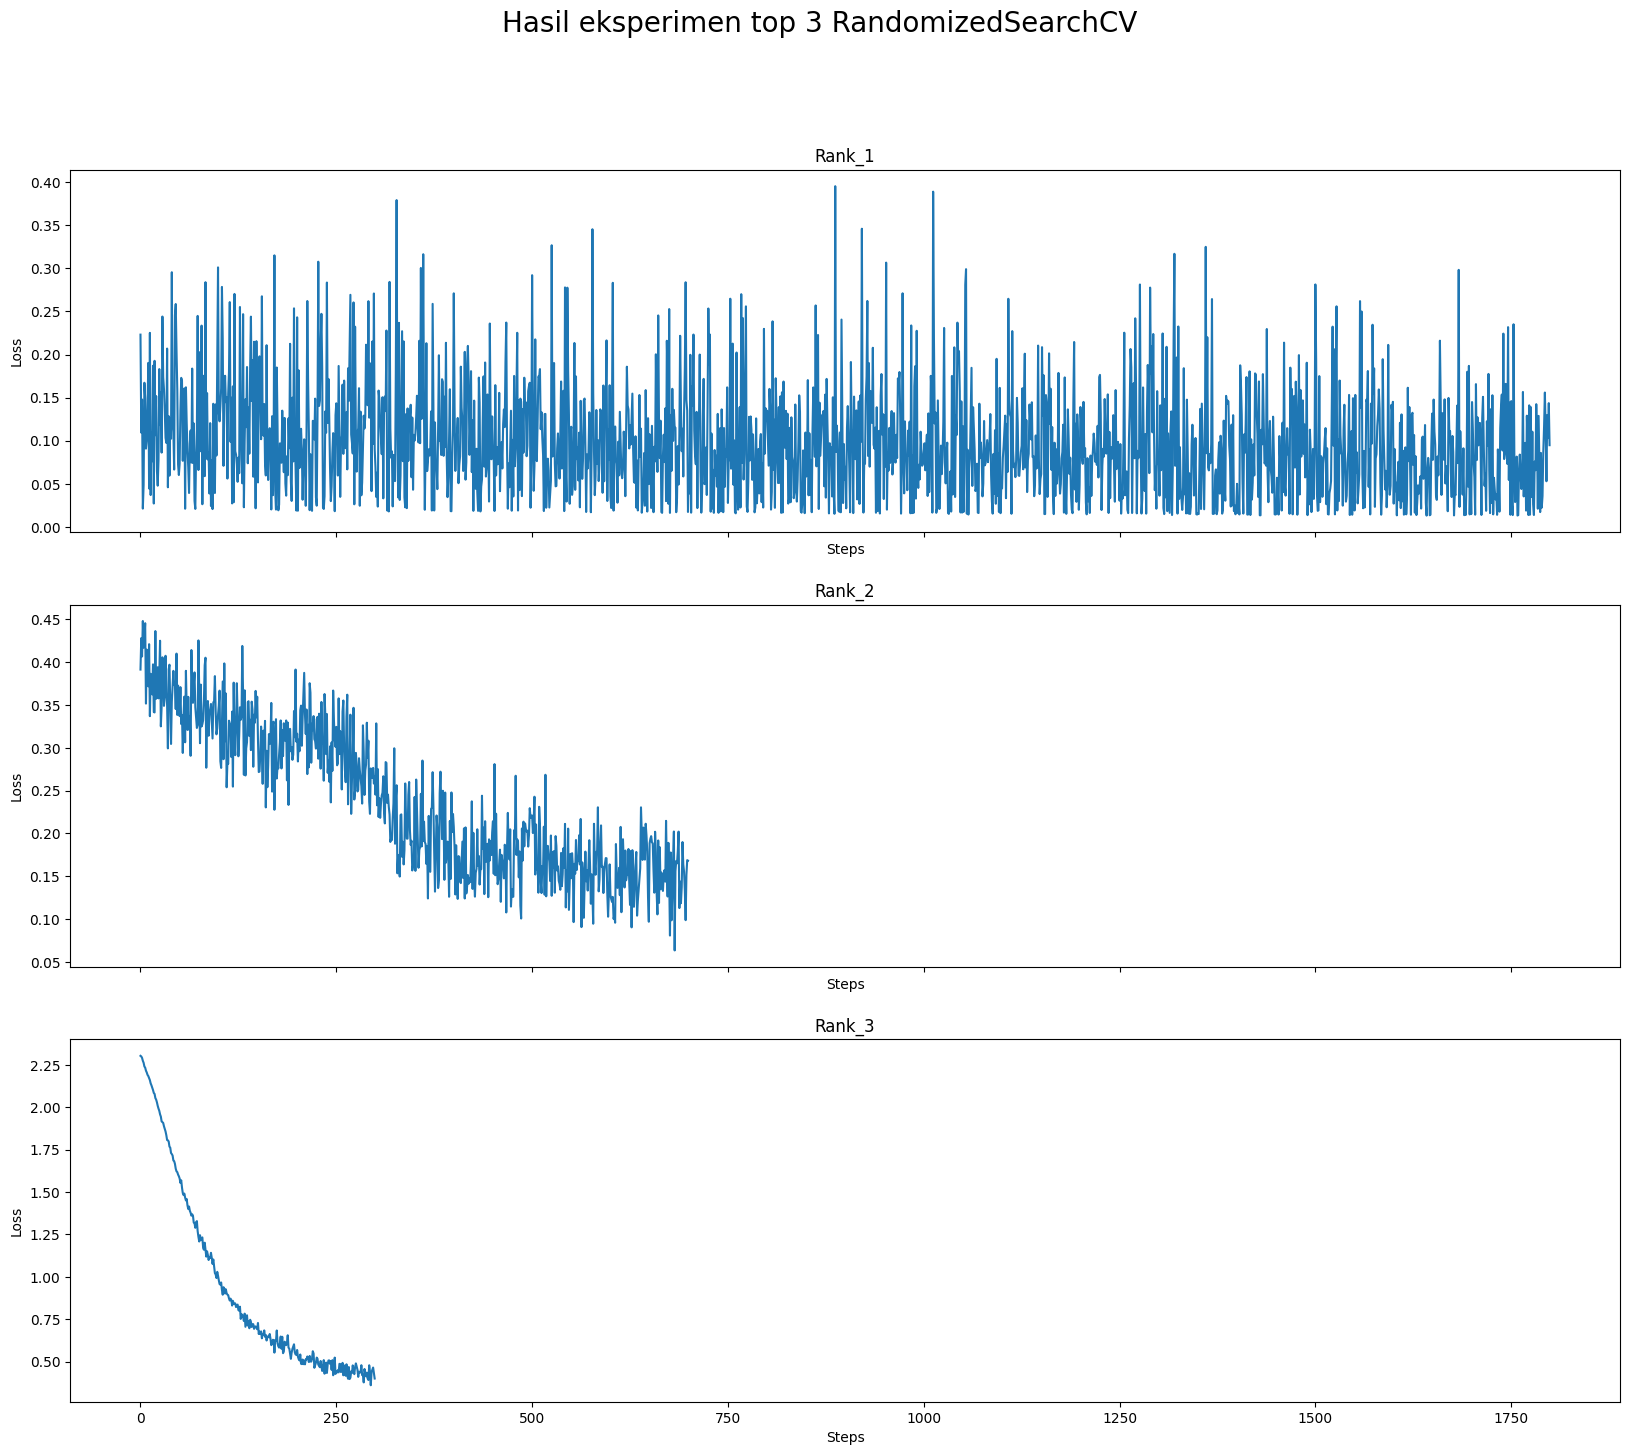

In [67]:
fig, axs = plt.subplots(3, sharex=True, figsize=(20,16))
fig.suptitle("Hasil eksperimen top 3 RandomizedSearchCV", fontsize=20)
axs[0].plot(range(len(all_losses[2])), all_losses[2])
axs[0].set_title("Rank_1")
axs[1].plot(range(len(all_losses[1])), all_losses[1])
axs[1].set_title("Rank_2")
axs[2].plot(range(len(all_losses[0])), all_losses[0])
axs[2].set_title("Rank_3")

for ax in axs.flat:
  ax.set(xlabel='Steps', ylabel='Loss')

plt.show()